In [3]:
# import os
import glob
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

from smartcar.utils.files import get_data_paths

In [ ]:
BATCH_SIZE = 16

def normalize_label(old_val, old_min, old_max, new_min, new_max):
    old_val = float(old_val)
    new_val = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    return new_val

def padding_img_id(string_i):
    padding = 7 - len(string_i)
    for i in range(padding):
        string_i = "0" + string_i
    return string_i

In [4]:
data_dir = "C:\Projects\SmartCar\data"

image_plist, label_plist = get_data_paths(data_dir)

In [ ]:
files = parse.get_filenames(data_dir)
flip_dir = data_dir
if not os.path.exists(flip_dir):
    os.makedirs(flip_dir)
    
def flip_angle(label):
    if (label >= 125):
        diff = label - 125
        return 125 - diff
    else:
        diff = 125 - label
        return 125 + diff
    
def flip_dataset(files, directory):
    files = sorted(files)
    i = int(files[len(files) - 1].split("_")[0].split("/")[3]) + 1
    print(i)
    for f in files:
        img = cv2.imread(f, 1)
        img = cv2.flip(img, 1)
        f = f.split("_")
        angle = f[1]
        speed = f[2].rstrip(f[2][-4:])
        angle = flip_angle(int(angle))
        img_path = directory + str(i) + "_" + str(angle) + "_" + str(speed) + ".jpg"
        cv2.imwrite(img_path, img)
        print(img_path)
        i += 1
flip_dataset(files, data_dir)

In [2]:
image_paths = []
angle_labels = []
speed_labels = []
for root, dirs, files in os.walk(data_dir):
    nb_data = len(files)
    for file in files:
        if file.endswith(".jpg"):
            filename = os.path.join(root, file)
            image_paths.append(filename)
            s = filename.split("_")
            #print("angle:",float(s[1]), "speed:", float(s[2].rstrip(s[2][-4:])))
            angle_labels.append(float(s[1]))
            speed_labels.append(float(s[2].rstrip(s[2][-4:])))
image_paths = np.array(image_paths)
angle_labels = np.array(angle_labels)
speed_labels = np.array(speed_labels)

In [3]:
angle_labels = ((angle_labels - 35) / 170.0 - 0.5) * 2
idx = 0
for spd in speed_labels:
    speed_labels[idx] = normalize_label(spd, 40, 102, 0, 1)
    idx += 1

In [4]:
print(str(angle_labels))

[0.05882353 0.05882353 0.05882353 ... 0.95294118 0.85882353 0.05882353]


In [5]:
print(str(speed_labels))

[0.         1.         1.         ... 0.75806452 0.82258065 1.        ]


In [6]:
print(image_paths.shape, angle_labels.shape, speed_labels.shape)

(23254,) (23254,) (23254,)


from random import shuffle

def build_dataset(datas):
    dataset = np.zeros((datas.shape[0], 120, 160, 3))
    for i in range(datas.shape[0]):    
        img = cv2.imread(datas[i])
        y1 = int(img.shape[0] / 2)
        img = img[y1:, :]
        img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
        dataset[i, :, :, :] = img
    return dataset

def myGenerator(datas, angle_labels, speed_labels, batch=16):
    i = 0
    while (True):
        loaded_img = build_dataset(datas[i:(i + batch)])
        
        nb_batch = i
        x = np.zeros((batch, 120, 160, 3))
        y_angle = np.zeros((batch,))
        y_speed = np.zeros((batch,))
        u = 0
        while (nb_batch < i + batch and nb_batch < datas.shape[0]):
            print("i:",nb_batch,"u:",u,"angle:",angle_labels[nb_batch],"speed:",speed_labels[nb_batch])
            cv2.imwrite("i" + padding_img_id(str(nb_batch)) + ".png", loaded_img[u])
            x[u, :, :, :] = loaded_img[u]
            #print("i:", nb_batch, "angle:", angle_labels[nb_batch], "speed:", speed_labels[nb_batch])
            y_angle[u] = angle_labels[nb_batch]
            y_speed[u] = speed_labels[nb_batch]
            nb_batch += 1
            u += 1
        i += batch
        yield x, [y_angle, y_speed]

In [7]:
from random import shuffle

def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1[:,:,2][image1[:,:,2] > 255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def build_dataset(datas):
    dataset = np.zeros((len(datas), 120, 160, 3))
    for i in range(len(datas)):
        img = cv2.imread(datas[i])
        img = augment_brightness(img)
        y1 = int(img.shape[0] / 2)
        img = img[y1:, :]
        img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
        dataset[i, :, :, :] = img
    return dataset

def myGenerator(datas, angle_labels, speed_labels, batch=16):
    # For each epoch
    while 1:
        # Suffle datas
        indexes_tmp = list(range(len(datas)))
        indexes = []
        for j in range(3):
            indexes += indexes_tmp
        shuffle(indexes)
        
        # For each batch
        for i in range(0, len(indexes), batch):
            
            # Build a batch of datas
            batch_data = [datas[indexes[j]] for j in range(i, i + batch) if j < len(indexes)]
            y_angle = [angle_labels[indexes[j]] for j in range(i, i + batch) if j < len(indexes)]
            y_speed = [speed_labels[indexes[j]] for j in range(i, i + batch) if j < len(indexes)]
    
            y_angle = np.array(y_angle)
            y_speed = np.array(y_speed)
            # Build the dataset for the batch
            x = build_dataset(batch_data)
            
            yield x, [y_angle, y_speed]

In [8]:
sep_train = int(nb_data * 0.8)
sep_test = nb_data - sep_train
gen_train = myGenerator(image_paths[:sep_train], angle_labels[:sep_train], speed_labels[:sep_train], BATCH_SIZE)
gen_test = myGenerator(image_paths[sep_train:], angle_labels[sep_train:], speed_labels[sep_train:], BATCH_SIZE)

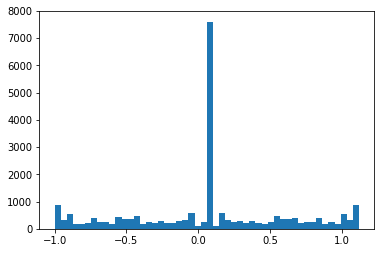

In [9]:
plt.hist(angle_labels, bins=50)
plt.show()

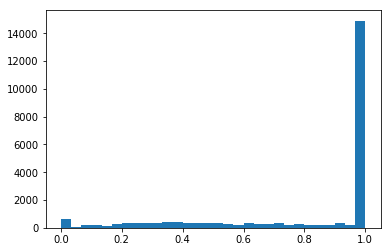

In [10]:
plt.hist(speed_labels, bins=30)
plt.show()

In [11]:
def AnglePredCnn():
    img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='linear')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='linear')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    #continous output of throttle
    throttle_out = Dense(1, activation='linear', name='throttle_out')(x)      # Reduce to 1 number, Positive number only
    #out = Dense(2, activation='linear', name='model_outputs')(x)
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])#outputs=[out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  #loss={'model_outputs' : 'mean_squared_error'})
                  loss_weights={'angle_out': 0.9, 'throttle_out': .001})
    return model

In [12]:
model = AnglePredCnn()

In [ ]:
model_path = os.path.abspath("models/model_aug_bright.h5")
checkpointer = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
hist = model.fit_generator(generator=gen_train,
                           validation_data=gen_test,
                           steps_per_epoch=(sep_train * 3 / BATCH_SIZE),
                           validation_steps=(sep_test * 3 / BATCH_SIZE),
                           epochs=10,
                           shuffle=True,
                           callbacks=[checkpointer])

Epoch 1/10
3489/3488 [==============================] - 1659s 476ms/step - loss: 1.1313 - angle_out_loss: 1.2567 - throttle_out_loss: 0.2683 - val_loss: 0.1405 - val_angle_out_loss: 0.1560 - val_throttle_out_loss: 0.0855
Epoch 2/10
3489/3488 [==============================] - 1476s 423ms/step - loss: 0.1074 - angle_out_loss: 0.1192 - throttle_out_loss: 0.0986 - val_loss: 0.1112 - val_angle_out_loss: 0.1235 - val_throttle_out_loss: 0.0766
Epoch 3/10
3489/3488 [==============================] - 1539s 441ms/step - loss: 0.2685 - angle_out_loss: 0.2982 - throttle_out_loss: 0.0943 - val_loss: 0.2864 - val_angle_out_loss: 0.3181 - val_throttle_out_loss: 0.0754
Epoch 4/10
2491/3488 [====================>.........] - ETA: 5:55 - loss: 0.2687 - angle_out_loss: 0.2984 - throttle_out_loss: 0.0942

In [ ]:
plt.plot(hist.history["loss"][1:])
plt.plot(hist.history["val_loss"][1:])
plt.show()